In [1]:
import os
from dotenv import load_dotenv
import nibabel as nib
from nibabel.orientations import aff2axcodes
import h5py
import pandas as pd
import numpy as np
from tqdm import tqdm

from utils.registration import nifit_info, correct4registration, slice2chunk_align
from utils.preproc import FUSCleaner

from utils.glm import run_glm_analysis
from nilearn.glm.contrasts import compute_contrast
from scipy.ndimage import affine_transform
import SimpleITK as sitk

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from joblib import Parallel, delayed

In [2]:
load_dotenv()
base_dir = os.getenv('BASE_DIR')
task_dir = os.path.join(base_dir, 'task_data')
register_dir = os.path.join(base_dir, 'slice2chunk_grouper', '061824_1-5')
figure_dir = os.path.join(base_dir, 'figures')

os.makedirs(figure_dir, exist_ok=True)

# Registration

In [ ]:
def transform_affine(affine_matrix):
    # Make a copy to avoid modifying the original matrix
    transformed_matrix = affine_matrix.copy()
    
    # Flip the signs of the first and third diagonal elements
    transformed_matrix[0, 0] = -affine_matrix[0, 0]
    transformed_matrix[2, 2] = -affine_matrix[2, 2]
    
    # Set the translation components (last column) to 0
    transformed_matrix[0, 3] = 0
    transformed_matrix[2, 3] = 0
    
    return transformed_matrix

In [5]:
raw_file = os.path.join(task_dir, '0618_livemarmoset_plane1.5.nii')
raw_file2 = os.path.join(register_dir, '0618_livemarmoset_plane1.5.nii.gz')

raw_image = nib.load(raw_file)
raw_image2 = nib.load(raw_file2)

aff2axcodes(raw_image.affine), aff2axcodes(raw_image2.affine)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


(('L', 'A', 'S'), ('R', 'A', 'I'))

In [8]:
def load_nifti_image(file_path: str):
    """Loads a NIfTI image and returns its data array and affine matrix."""
    img = nib.load(file_path)
    data = img.get_fdata()
    affine = img.affine
    return data, affine, img.header


def process_and_save_image(first_img_path: str, second_img_path: str, output_path: str):
    """Loads the images, applies affine corrections, flips the data, and saves the corrected image."""
    # Load the first image (4D) and the second image (corrected slice)
    first_data, _, _ = load_nifti_image(first_img_path)
    _, second_affine, second_header = load_nifti_image(second_img_path)

    corrected_affine = second_affine.copy()
    corrected_affine[[0, 1]] = corrected_affine[[1, 0]]

    print("Corrected Affine:\n", corrected_affine)
    print(aff2axcodes(corrected_affine))
    
    # reflect z to be positive
    transform_matrix = np.array([[1, 0, 0, 0],
                                [0, 1, 0, 0],
                                [0, 0, -1, 0],
                                [0, 0, 0, 1]])

    transformed_affine = corrected_affine @ transform_matrix

    print(transformed_affine)

    flipped_data = np.flip(first_data, axis=2)

    new_img = nib.Nifti1Image(flipped_data, transformed_affine, second_header)

    nib.save(new_img, output_path)
    print(f"Corrected image saved to {output_path}")

In [10]:
# correct 2D image for landmark registration
outfile = os.path.join(register_dir, 'Grouper_livemarmoset_0618_2D_corrected.nii.gz')
correct4registration(raw_file2, outfile)

# correct 2D x timepoints for later analysis
output_path = os.path.join(register_dir, 'Grouper_livemarmoset_0618_2D_timepoints_corrected.nii.gz')
process_and_save_image(raw_file, raw_file2, output_path)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


Corrected Affine:
 [[ 0.          0.40000001  0.         -0.        ]
 [ 0.11        0.          0.         -0.        ]
 [ 0.          0.         -0.09856     0.        ]
 [ 0.          0.          0.          1.        ]]
('A', 'R', 'I')
[[0.         0.40000001 0.         0.        ]
 [0.11       0.         0.         0.        ]
 [0.         0.         0.09856    0.        ]
 [0.         0.         0.         1.        ]]
Corrected Affine:
 [[ 0.          0.40000001  0.         -0.        ]
 [ 0.11        0.          0.         -0.        ]
 [ 0.          0.         -0.09856     0.        ]
 [ 0.          0.          0.          1.        ]]
('A', 'R', 'I')
[[0.         0.40000001 0.         0.        ]
 [0.11       0.         0.         0.        ]
 [0.         0.         0.09856    0.        ]
 [0.         0.         0.         1.        ]]
Corrected image saved to /Users/yibeichen/Desktop/fusi/slice2chunk_grouper/061824_1-5/Grouper_livemarmoset_2D_timepoints_corrected.nii.gz


In [3]:
aligned_2d_file = os.path.join(register_dir, 'Grouper_livemarmoset_0618_2D_corrected-transformed.nii.gz')
corrected_ts_file = os.path.join(register_dir, 'Grouper_livemarmoset_0618_2D_timepoints_corrected.nii.gz')
transform_mtx_file = os.path.join(register_dir, 'Transform.h5')

In [5]:
with h5py.File(transform_mtx_file, 'r') as f:
    # Inspect the keys to check where the matrix parameters are stored
    print(list(f.keys()))
    print(list(f['TransformGroup'].keys()))

    # Assuming the affine parameters are stored under 'TransformParameters'
    transform_parameters = np.array(f['TransformGroup/0/TransformParameters'])
    print(f"Transform Parameters: {transform_parameters}")

    # Also, you might want to extract 'TransformFixedParameters' for the origin
    fixed_parameters = np.array(f['TransformGroup/0/TransformFixedParameters'])
    print(f"Fixed Parameters: {fixed_parameters}")

M = np.eye(4)
M[:3, :3] = np.reshape(transform_parameters[:9], (3, 3))  # Rotation/scaling
M[:3, 3] = transform_parameters[9:12]  # Translation

print(f"Affine Matrix: \n{M}")

['HDFVersion', 'ITKVersion', 'OSName', 'OSVersion', 'TransformGroup']
['0']
Transform Parameters: [ 9.99793902e-01 -1.15001113e-03  2.02689588e-02 -7.76484799e-06
  9.98372566e-01  5.70282286e-02 -2.03015555e-02 -5.70166326e-02
  9.98166795e-01  9.17588919e-01 -1.18879569e+00 -7.08504770e+00]
Fixed Parameters: [0. 0. 0.]
Affine Matrix: 
[[ 9.99793902e-01 -1.15001113e-03  2.02689588e-02  9.17588919e-01]
 [-7.76484799e-06  9.98372566e-01  5.70282286e-02 -1.18879569e+00]
 [-2.03015555e-02 -5.70166326e-02  9.98166795e-01 -7.08504770e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [4]:
# Read the 4D moving image using SimpleITK
sitk_moving_4d_image = sitk.ReadImage(corrected_ts_file)
sitk_fixed_image = sitk.ReadImage(aligned_2d_file)

with h5py.File(transform_mtx_file, 'r') as f:
    transform_parameters = np.array(f['TransformGroup/0/TransformParameters'])
    fixed_parameters = np.array(f['TransformGroup/0/TransformFixedParameters'])

affine_transform = sitk.AffineTransform(3) 
affine_transform.SetMatrix(transform_parameters[:9])  
affine_transform.SetTranslation(transform_parameters[9:12]) 

if len(fixed_parameters) > 0:
    affine_transform.SetFixedParameters(fixed_parameters)

num_timepoints = sitk_moving_4d_image.GetSize()[-1] 

In [5]:
transformed_4d_image = []
# Loop over each time point, apply the transformation, and resample the image
for t in tqdm(range(num_timepoints)):
    # Define the extraction size: 3D spatial size and 0 for time dimension (to extract a 3D image)
    extract_size = list(sitk_moving_4d_image.GetSize())
    extract_size[-1] = 0  # Set the time dimension to 0 to extract a 3D slice

    # Define the extraction index: start at (0, 0, 0) in spatial dimensions, at time t
    extract_index = [0, 0, 0, t]

    # Extract the 3D image at time point t
    sitk_moving_image_3d = sitk.Extract(sitk_moving_4d_image, extract_size, extract_index)
    
    # Resample the 3D image to the fixed image space
    resampled_image_3d = sitk.Resample(
        sitk_moving_image_3d,                # Moving 3D image (at time t)
        sitk_fixed_image,                    # Fixed image (C)
        affine_transform,                    # Affine transformation matrix M
        sitk.sitkLinear,                     # Interpolation method (linear)
        0.0,                                 # Default value for out-of-bound pixels
        sitk_moving_image_3d.GetPixelID()    # Pixel type
    )
    
    transformed_array = sitk.GetArrayFromImage(resampled_image_3d)[:, :, 79:81].transpose(2, 1, 0)
    
    transformed_4d_image.append(transformed_array)

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:38<?, ?it/s]


KeyboardInterrupt: 

# Preprocessing

detrending, low high pass filter, normalization

In [3]:
raw_ts_file = os.path.join(task_dir, '0618_livemarmoset_plane1.5.nii')
transformed_ts_file = os.path.join(task_dir,'grouper_livemarmoset_0618_ts_transformed.npy')

raw_ts = nib.load(raw_ts_file).get_fdata()
transformed_ts = np.load(transformed_ts_file)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


In [178]:
def plot_preprocessing_steps_raw(data, step_name):
    # Step 1: Heatmap of average across time
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    avg_time_data = np.mean(data[:, 0, :, :], axis=-1)
    sns.heatmap(avg_time_data.T, cmap="viridis")
    plt.title(f"{step_name}: Average Across Time")

    # Step 2: Mean time series (averaging all pixels)
    plt.subplot(1, 2, 2)
    mean_time_series = np.mean(data[:, 0, :, :], axis=(0, 1))
    plt.plot(mean_time_series)
    plt.title(f"{step_name}: Average Across Pixels")
    plt.xlabel("Time (TRs)")
    plt.ylabel("Signal")

    plt.tight_layout()
    plt.show()

def plot_preprocessing_steps_transformed(data, step_name):
    # Step 1: Heatmap of average across time
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    avg_time_data = np.mean(data[0, :, :, :], axis=-1)
    sns.heatmap(np.rot90(avg_time_data), cmap="viridis")
    plt.title(f"{step_name}: Average Across Time")

    # Step 2: Mean time series (averaging all pixels)
    plt.subplot(1, 2, 2)
    mean_time_series = np.mean(data[0, :, :, :], axis=(0, 1))
    plt.plot(mean_time_series)
    plt.title(f"{step_name}: Average Across Pixels")
    plt.xlabel("Time (TRs)")
    plt.ylabel("Signal")

    plt.tight_layout()
    plt.show()

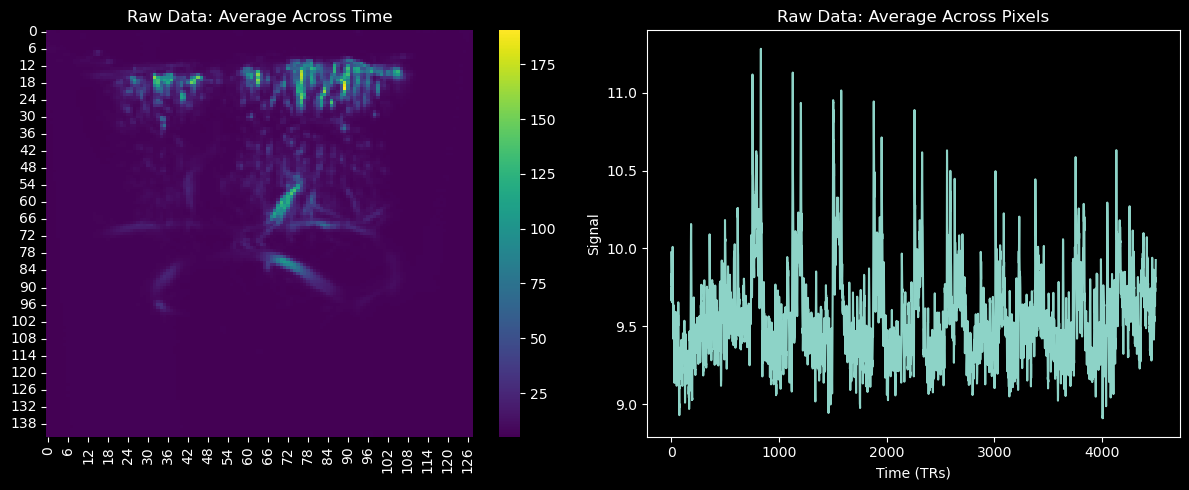

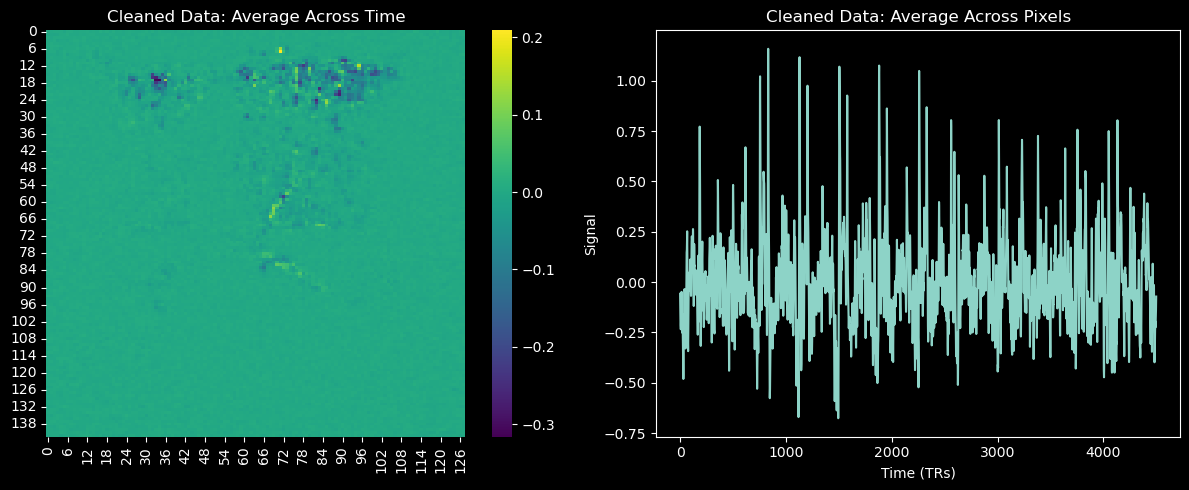

In [179]:
cleaner = FUSCleaner(detrend=True, standardize=False, low_pass=0.8, high_pass=0.01, fs=2.5, sigma=1)

cleaned_raw_data = cleaner.clean(raw_ts)


plot_preprocessing_steps_raw(raw_ts, "Raw Data")
plot_preprocessing_steps_raw(cleaned_raw_data, "Cleaned Data")


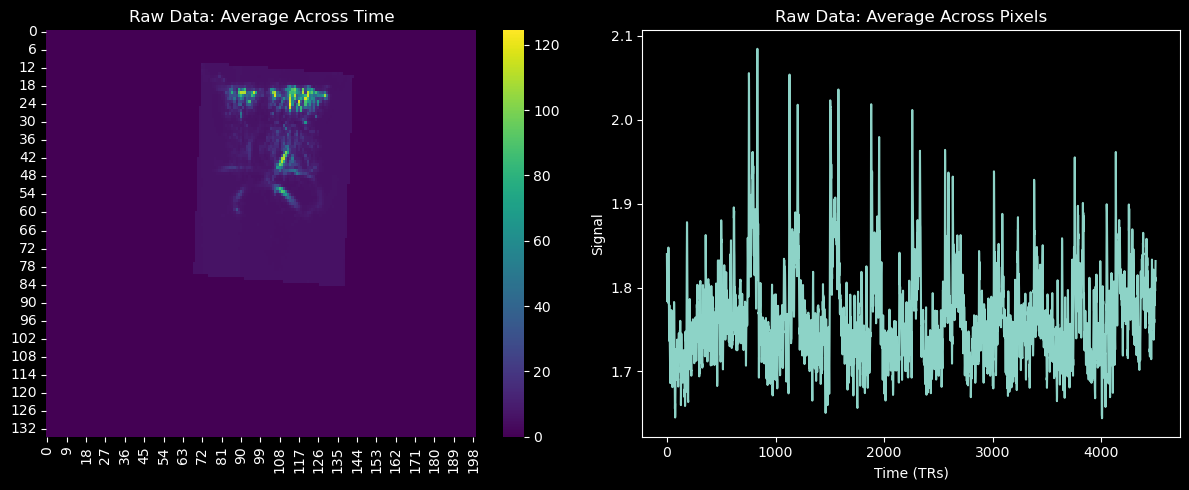

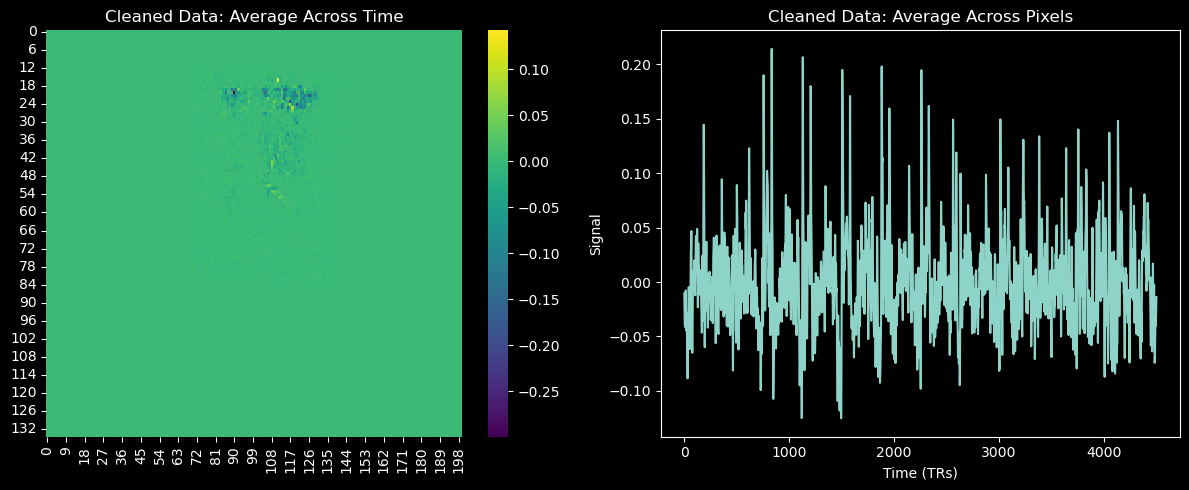

In [180]:
cleaner = FUSCleaner(detrend=True, standardize=False, low_pass=0.8, high_pass=0.01, fs=2.5, sigma=1)

cleaned_transformed_data = cleaner.clean(transformed_ts)


plot_preprocessing_steps_transformed(transformed_ts, "Raw Data")
plot_preprocessing_steps_transformed(cleaned_transformed_data, "Cleaned Data")


# Region signal extraction

In [15]:
cortical_atlas_file = os.path.join(base_dir, "atlas", "atlas_MBM_cortex_vH.nii.gz")
# subcortical_atlas_file = os.path.join(base_dir, "atlas", "SAMv1.0.nii.gz")
subcortical_atlas_file = os.path.join(base_dir, "atlas", "atlas_MBM_subcortical_beta.nii.gz")

cortical_atlas = nib.load(cortical_atlas_file).get_fdata()[79:81, :, :]
subcortical_atlas = nib.load(subcortical_atlas_file).get_fdata()[79:81, :, :]

In [62]:
def extract_region_data(atlas, cleaned_data, region_shift=0):
    """
    Extract region-specific data from the cleaned data using the provided atlas.

    Parameters:
    - atlas: 3D numpy array of shape (x, y, z) representing the region atlas
    - cleaned_data: 4D numpy array of shape (x, y, z, n_TR) representing the cleaned fMRI data
    - region_shift: int, value to shift the region labels (default=0 for cortex, 200 for subcortex)
    - binary_mask: bool, whether to binarize the atlas mask based on the first time point (for approach 1)
    
    Returns:
    - region_data: dict, where keys are region labels and values are arrays of shape (n_voxel, n_TR)
    """
    # Shift region labels if needed (for subcortex)
    if region_shift:
        atlas = atlas + region_shift


    atlas_binary = (atlas > 0).astype(int)
    masked_data = atlas_binary[..., np.newaxis] * cleaned_data

    unique_regions = np.unique(atlas)
    unique_regions = unique_regions[(unique_regions != 0) & (unique_regions != region_shift)]

    region_data = {}

    for region in unique_regions:
        region_mask = (atlas == region)
        extracted_region_data = masked_data[region_mask, :].reshape(-1, cleaned_data.shape[-1])
        region_data[str(int(region))] = extracted_region_data

    return masked_data, region_data

In [63]:

cortex_masked_data, cortical_region_data = extract_region_data(cortical_atlas, cleaned_transformed_data, region_shift=0) 
subcortex_masked_data, subcortical_region_data = extract_region_data(subcortical_atlas, cleaned_transformed_data, region_shift=200)


In [69]:
cortical_region_data.keys(), subcortical_region_data.keys()

(dict_keys(['1', '2', '3', '5', '10', '11', '12', '13', '14', '15', '16', '18', '20', '25', '28', '30', '67', '79', '80', '81', '82', '83', '85', '86', '87', '89', '90', '91', '92', '93', '101', '102', '103', '105']),
 dict_keys(['203', '208', '210', '212', '213', '215', '216', '218', '220']))

In [84]:
n_TR = cleaned_transformed_data.shape[-1]
mean_cortex = np.zeros((len(cortical_region_data.keys()), n_TR))
mean_subcortex = np.zeros((len(subcortical_region_data.keys()), n_TR))

for i, key in enumerate(cortical_region_data.keys()):
    mean_cortex[i, :] = np.mean(cortical_region_data[key], axis=0)

for i, key in enumerate(subcortical_region_data.keys()):
    mean_subcortex[i, :] = np.mean(subcortical_region_data[key], axis=0)

In [45]:
def generate_label_index_dict(cortical_labels, subcortical_labels_df, region_shift=200):
    subcortical_labels_df["Labels"] += region_shift
    subcortical_labels = dict(zip(subcortical_labels_df["Name"], subcortical_labels_df["Labels"]))
    label_dict = cortical_labels | subcortical_labels
    
    for k, v in label_dict.items():
        label_dict[k] = np.array(v)
    
    idx = np.arange(1, len(label_dict.keys()) + 1)
    return dict(zip(label_dict.keys(), idx)), label_dict

In [205]:
cortical_labels = {
    "DLPFC": np.arange(1,6,1),
    "VLPFC": np.arange(6,10,1),
    "MPFC": np.arange(10,17,1),
    "OFC": np.arange(17,24,1),
    "Motor and premotor": np.arange(24,29,1),
    "Somatosensory": np.arange(29,34,1),
    "Auditory": np.arange(34,40,1),
    "Insula and others": np.arange(40,47,1),
    "Lateral and inferior temporal": np.arange(47,58,1),
    "Ventral temporal": np.arange(58,67,1),
    "Posterior parietal": np.arange(67,79,1),
    "PCC ": np.arange(79,89,1),
    "Visual": np.arange(89,107,1),
}

subcortical_labels_df = pd.read_csv(os.path.join(base_dir, "atlas", "atlas_MBM_subcortical_beta_label.csv"))

label_idx_dict, label_dict = generate_label_index_dict(cortical_labels, subcortical_labels_df, region_shift=200)


In [206]:
def get_label_list(region_data, label_dict):
    label_list = []
    for key in region_data.keys():
        for i, n in label_dict.items():
            if int(key) in n:
                label_list.append(i)
    return label_list

In [207]:
cortical_labels = get_label_list(cortical_region_data, label_dict)
subcortical_labels = get_label_list(subcortical_region_data, label_dict)

In [208]:
def plot_heatmap_with_colorbar(data, region_categories, event_sec, filename, vmin=None, vmax=None, TR=2.5):
    """
    Plots a heatmap of the data with a colorbar that represents region categories.
    Adds vertical lines based on event_sec and replaces x-tick labels with event_sec.

    Parameters:
    - data: 2D numpy array of shape (n_regions, n_TR) representing the time series data
    - region_categories: List of region categories corresponding to each region
    - event_sec: List of event times in seconds
    - TR: Sampling rate of the data in Hz (default=2.5 Hz)
    - vmin, vmax: Range of values for the heatmap colormap
    """
    # Maintain the original category order, using a set to find the unique categories while keeping order
    unique_categories = list(dict.fromkeys(region_categories))  # This will preserve the order

    # Map categories to integers
    category_map = {cat: i for i, cat in enumerate(unique_categories)}

    # Generate a 1-column array to represent the frequency of each category
    category_frequency = np.zeros((len(region_categories), 1))
    for idx, category in enumerate(region_categories):
        category_frequency[idx] = category_map[category]

    # Create a colormap with distinct colors for the categories
    colors = sns.color_palette("Set1", len(unique_categories))
    cmap = ListedColormap(colors)

    # Create a time axis in seconds
    n_TR = data.shape[1]  # Number of TRs
    TR_time = 1 / TR  # Convert TR to time (seconds)
    time_axis = np.arange(n_TR) * TR_time  # Time in seconds

    # Compute the position to place each label at the center of its corresponding group
    label_positions = []
    previous_index = 0
    for category in unique_categories:
        count = region_categories.count(category)
        center_position = previous_index + count / 2  # Find the center of the group
        label_positions.append(center_position)
        previous_index += count

    # Create the figure with two subplots: one for the colorbar, one for the heatmap
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8), gridspec_kw={'width_ratios': [0.05, 0.95]})

    # Left plot: the colorbar based on the category frequency
    sns.heatmap(category_frequency, ax=ax1, cmap=cmap, cbar=False, yticklabels=False)

    # Add region category labels at the center of their respective sub-bars
    ax1.set_xticks([])
    ax1.set_yticks(label_positions)
    ax1.set_yticklabels(unique_categories, rotation=0, ha='right')

    # Right plot: the heatmap without y-ticks and y-labels
    sns.heatmap(data, ax=ax2, cmap='bwr', xticklabels=False, yticklabels=False, vmin=vmin, vmax=vmax)

    # Add vertical lines for each event and 30 seconds later
    for event in event_sec:
        ax2.axvline(x=event / TR_time, color='black', linestyle='dotted', linewidth=1)
        ax2.axvline(x=(event + 30) / TR_time, color='black', linestyle='dotted', linewidth=1)

    tick_positions = [event / TR_time for event in event_sec]  # Convert event times to TR indices
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels(np.round(event_sec, 1))  # Set x-ticks to event times

    # Set labels and title
    ax2.set_xlabel("Time (seconds)")
    # ax2.set_title("Signal Heatmap with Event Lines")

    plt.tight_layout()
    # savefig('heatmap_with_event_lines.png')
    plt.savefig(filename, dpi=300)
    plt.show()

In [209]:
event_sec = [300, 450, 600, 750, 900, 1050, 1200, 1350, 1500, 1650]

In [225]:
cortical_region_data.keys()

dict_keys(['1', '2', '3', '5', '10', '11', '12', '13', '14', '15', '16', '18', '20', '25', '28', '30', '67', '79', '80', '81', '82', '83', '85', '86', '87', '89', '90', '91', '92', '93', '101', '102', '103', '105'])

In [227]:
subcortical_region_data.keys()

dict_keys(['203', '208', '210', '212', '213', '215', '216', '218', '220'])

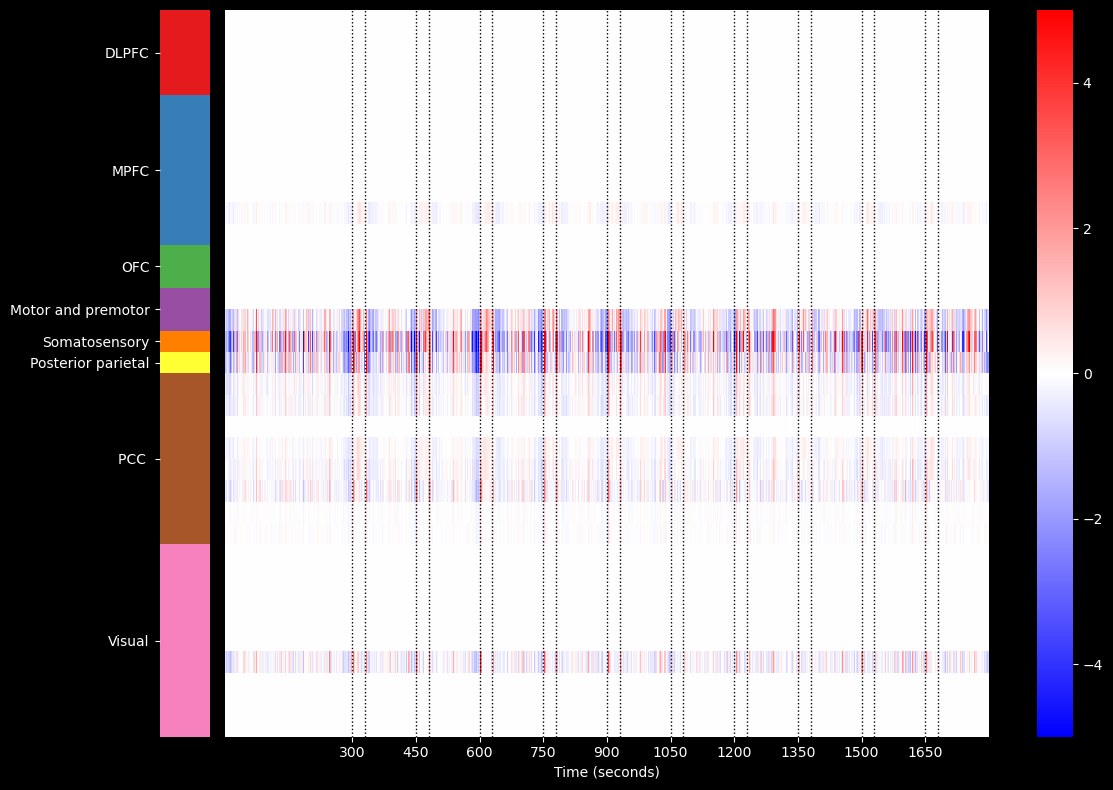

In [210]:
cortex_filename = os.path.join(figure_dir, 'cortex_heatmap.svg')
plot_heatmap_with_colorbar(mean_cortex, cortical_labels, event_sec, cortex_filename, vmin=-5, vmax=5)


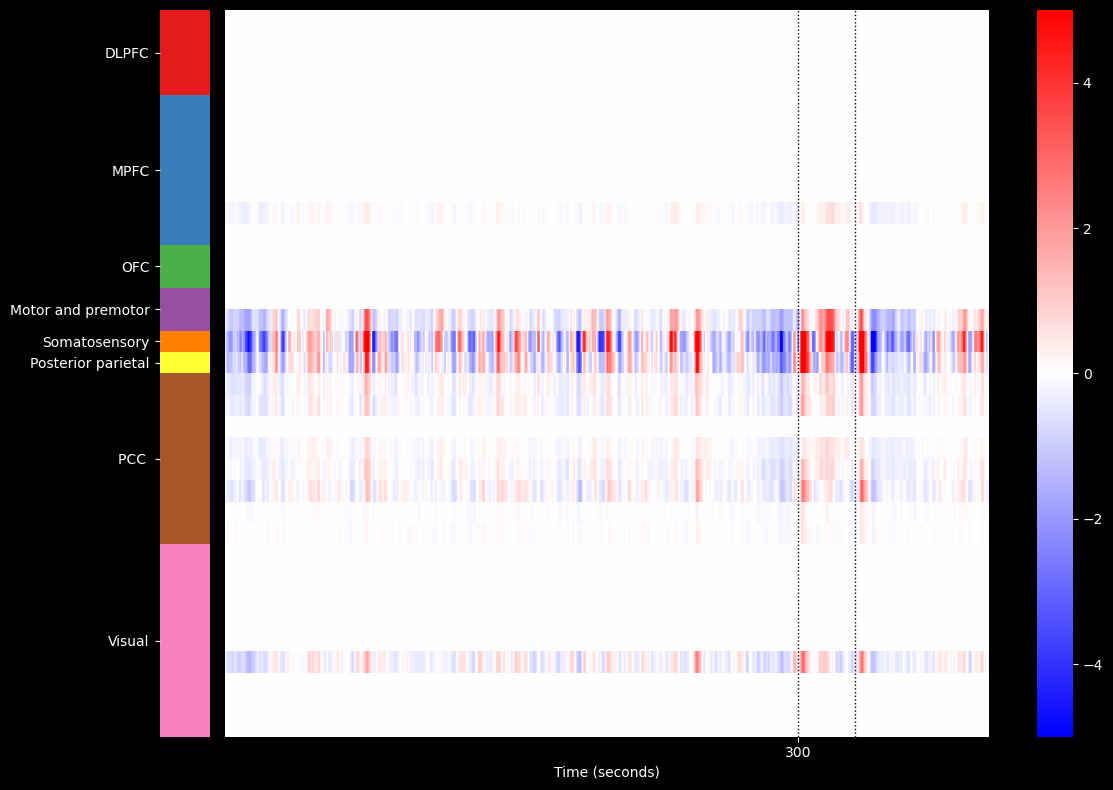

In [213]:
cortex_filename = os.path.join(figure_dir, 'cortex_heatmap_single_trial.svg')
plot_heatmap_with_colorbar(mean_cortex[:, :1000], cortical_labels, [300], cortex_filename, vmin=-5, vmax=5)


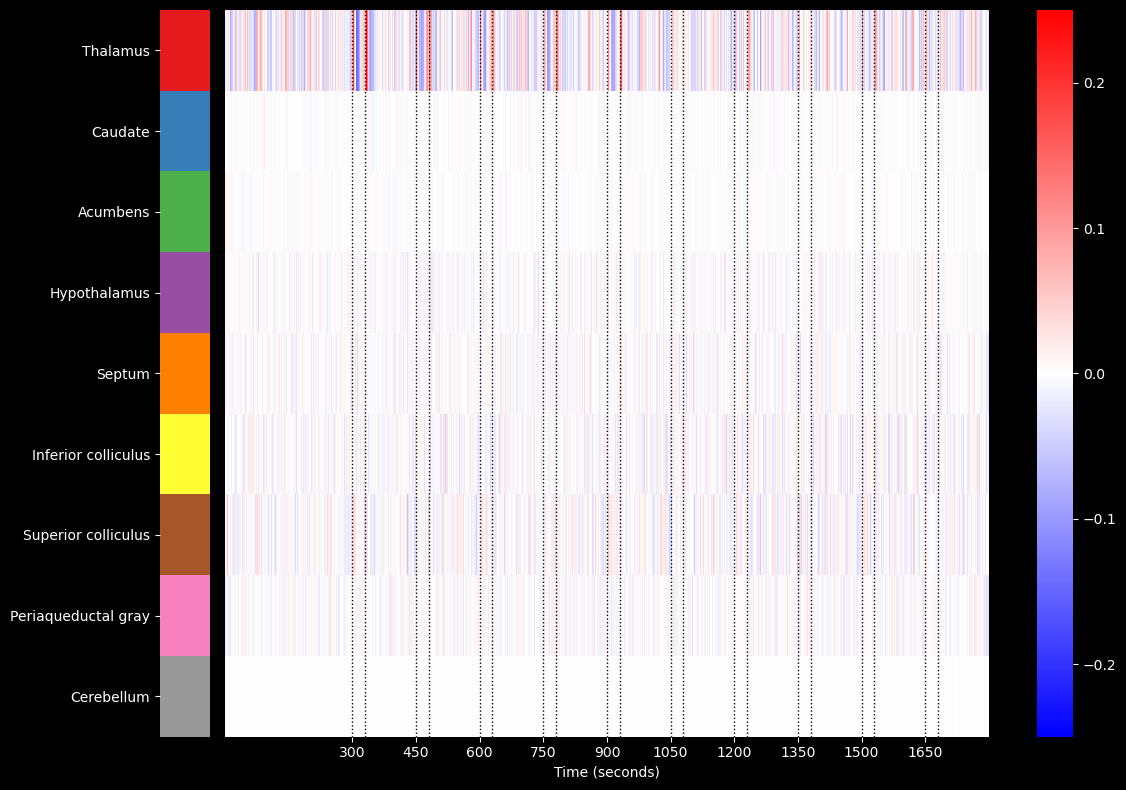

In [214]:
subcortex_filename = os.path.join(figure_dir, 'subcortex_heatmap.svg')
plot_heatmap_with_colorbar(mean_subcortex, subcortical_labels, event_sec, subcortex_filename, vmin=-0.25, vmax=0.25)


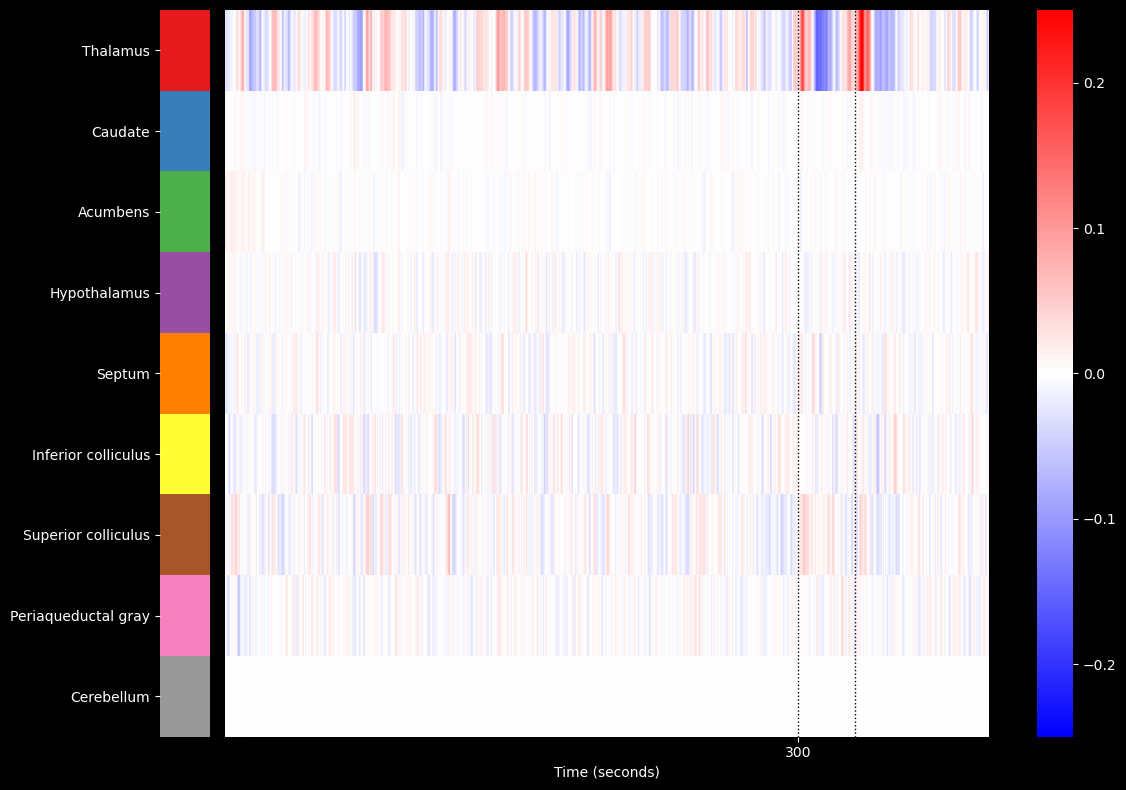

In [215]:
subcortex_filename = os.path.join(figure_dir, 'subcortex_heatmap_single_trial.svg')
plot_heatmap_with_colorbar(mean_subcortex[:, :1000], subcortical_labels, [300], subcortex_filename, vmin=-0.25, vmax=0.25)


In [228]:
selected_region = {
    "MPFC": np.mean(cortical_region_data['15'], axis=0),
    "Motor and premotor": np.mean(cortical_region_data['28'], axis=0),
    "Somatosensory": np.mean(cortical_region_data['30'], axis=0),
    "Posterior parietal": np.mean(cortical_region_data['67'], axis=0),
    "PCC": np.mean(np.array([np.mean(cortical_region_data[i], axis=0) for i in ['79', '80', '81', '82', '83', '85', '86', '87']]), axis=0),
    "Thalamus": np.mean(subcortical_region_data['203'], axis=0),
}


In [232]:
# conver selected_region to array
selected_region_array = np.array(list(selected_region.values()))
selected_region_array.shape

(6, 4500)

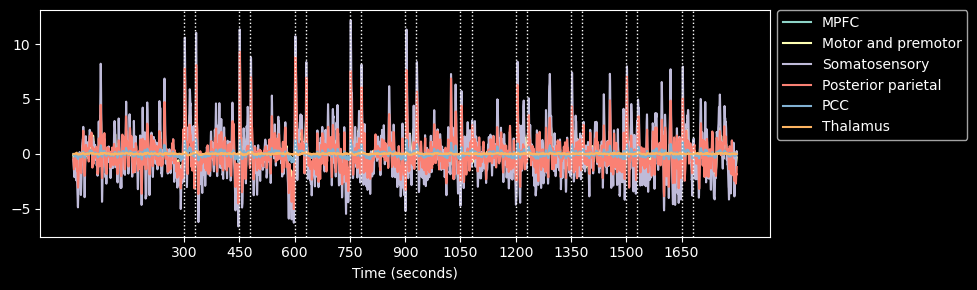

In [270]:
plt.figure(figsize=(10, 3))

# Plot each key's time series in a different color
for region, data in selected_region.items():
    plt.plot(data, label=region)

# Add vertical lines for each event
for event in event_sec:
    plt.axvline(x=event * 2.5, color='white', linestyle='dotted', linewidth=1)
    plt.axvline(x=(event+30) * 2.5, color='white', linestyle='dotted', linewidth=1)
#
#  Set the x-ticks to match the event positions
plt.xticks([event * sampling_rate for event in event_sec], labels=event_sec)
# Customize plot
plt.xlabel("Time (seconds)")
# plt.ylabel("Signal (e.g., Percent Signal Change)")
# plt.legend(loc='upper right')
# plt.title("Selected Cortical Regions Over Time with Event Markers")
# plt.grid(True)
plt.legend(bbox_to_anchor=(1.28, 1.03))

# Show plot
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'selected_region_time_series.svg'))
plt.show()

# GLM

In [4]:
event_frame = [750, 1125, 1500, 1875, 2250, 2625, 3000, 3375, 3750, 4125]
event_sec = [300, 450, 600, 750, 900, 1050, 1200, 1350, 1500, 1650]

In [5]:
event_df = pd.DataFrame(columns=['onset', 'trial_type', 'duration'], index=range(len(event_sec)))

event_df['onset'] = event_sec
event_df['trial_type'] = 'social'
event_df['duration'] = 30

In [17]:
def plot_atlas_with_labels(ax, atlas_data, slice_index, cmap='viridis', font_color='white', alpha=0.5):
    """
    Plots the atlas data with region labels on the corresponding areas.
    
    Parameters:
    - ax: Matplotlib axis object where the plot will be drawn.
    - atlas_data: 3D numpy array representing the atlas data.
    - slice_index: Index of the slice to be visualized.
    - cmap: Colormap for visualization.
    """
    # Plot the atlas data with a continuous colormap
    im = ax.imshow(np.rot90(atlas_data[slice_index, :, :]), cmap=cmap, alpha=alpha)

    # Get the unique labels in the slice and their positions
    unique_labels = np.unique(atlas_data[slice_index, :, :])

    # Loop through each unique label to place the label on the plot
    for label in unique_labels:
        if label == 0:
            continue
        # Find the coordinates of the label
        y, x = np.where(np.rot90(atlas_data[slice_index, :, :]) == label)
        
        # Place the label at the mean position of all points with the same value
        ax.text(np.mean(x), np.mean(y), str(int(label)), color=font_color,
                fontsize=8, ha='center', va='center')
    
    return im

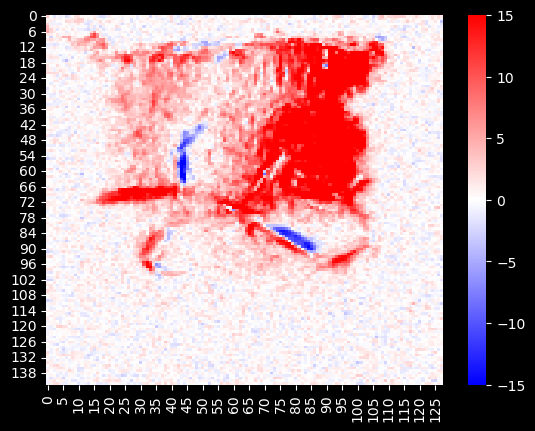

In [28]:
labels, estimators, X = run_glm_analysis(raw_ts[:, 0, :, :], event_df)
contrast_matrix = np.eye(X.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i]) for i, column in enumerate(X.columns)])
social = compute_contrast(labels, estimators, basic_contrasts['social'], stat_type='t').z_score()
sns.heatmap(social.reshape(raw_ts.shape[0], raw_ts.shape[2]).T, cmap="bwr", vmin=-15, vmax=15)
# plt.title("Social Stimulus Activation (Raw Data)")
# plt.savefig(os.path.join(figure_dir, 'social_GLM_heatmap_raw_data.svg'))
plt.show()

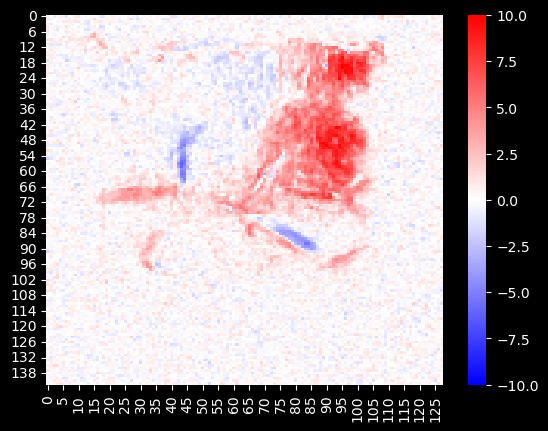

In [189]:
labels, estimators, X = run_glm_analysis(cleaned_raw_data[:,0,:,:], event_df)
contrast_matrix = np.eye(X.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i]) for i, column in enumerate(X.columns)])
social = compute_contrast(labels, estimators, basic_contrasts['social'], stat_type='t').z_score()
sns.heatmap(social.reshape(cleaned_raw_data.shape[0], cleaned_raw_data.shape[2]).T, cmap="bwr", vmin=-10, vmax=10)
# plt.title("Social Stimulus Activation (Raw Data)")
plt.savefig(os.path.join(figure_dir, 'social_GLM_heatmap_raw_data.svg'))
plt.show()

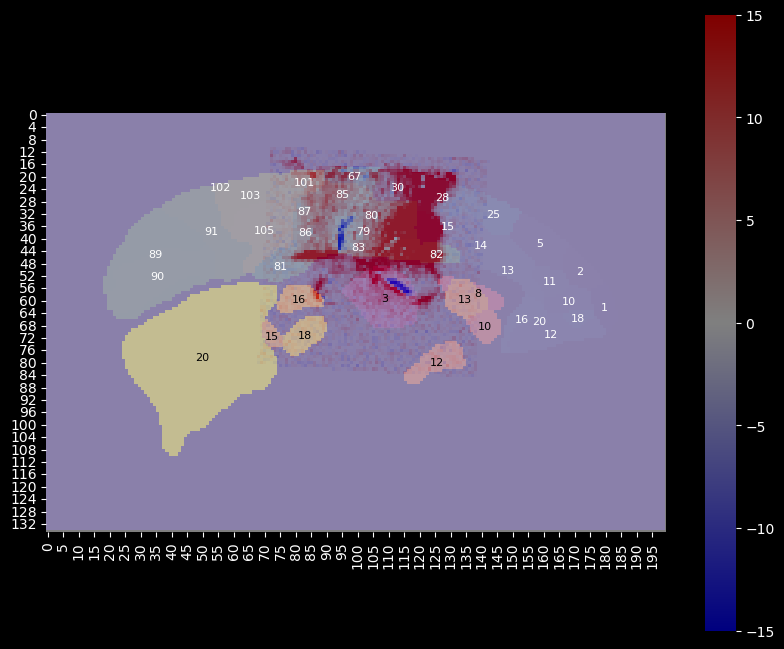

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
slice_index = 0
# Plot cortical atlas
plot_atlas_with_labels(ax, cortical_atlas, slice_index, cmap='viridis', font_color='white', alpha=0.5)

# Overlay subcortical atlas on the same plot
plot_atlas_with_labels(ax, subcortical_atlas, slice_index, cmap='plasma', font_color='black', alpha=0.5)

# Overlay normalized chunk data
im = sns.heatmap(np.rot90(social.reshape(transformed_ts.shape[1], transformed_ts.shape[2])), cmap="bwr", vmin=-15, vmax=15, alpha=0.5)

# # Add a colorbar
# plt.colorbar(im, ax=ax)
# plt.title(f"{title}")
plt.show()

/Users/yibeichen/micromamba/envs/neuro/lib/python3.10/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


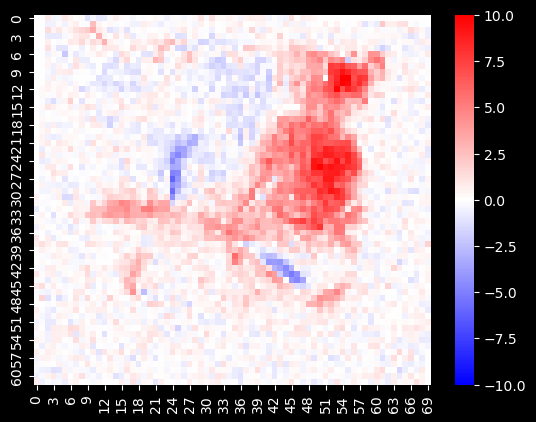

In [204]:
labels, estimators, X = run_glm_analysis(cleaned_transformed_data[0], event_df)
contrast_matrix = np.eye(X.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i]) for i, column in enumerate(X.columns)])
social = compute_contrast(labels, estimators, basic_contrasts['social'], stat_type='t').z_score()
sns.heatmap(np.rot90(social.reshape(cleaned_transformed_data.shape[1], cleaned_transformed_data.shape[2])[70:140, 60:122]), cmap="bwr", vmin=-10, vmax=10)
# plt.title("Social Stimulus Activation (Cleaned Data)")
plt.savefig(os.path.join(figure_dir, 'social_GLM_heatmap_transformed_data.svg'))
plt.show()

# PSTH

In [217]:
def extract_trial_data(task_data, event_frame, pre_sec=10, post_sec=40, sampling_rate=2.5):
    """
    Extract trial data from task data based on event frames.

    Parameters:
    - task_data: 2D numpy array of shape (n_region, n_frame) representing the time series data
    - event_frame: List of event frames (onsets) in terms of frame indices
    - pre_sec: Number of seconds to include before onset (default=10)
    - post_sec: Number of seconds to include after onset (default=40)
    - sampling_rate: Sampling rate in Hz (default=2.5 Hz)

    Returns:
    - trial_data: 3D numpy array of shape (n_region, n_frame_per_trial, n_trial)
    """
    n_region, n_frame = task_data.shape

    # Convert pre and post seconds to frames
    pre_frames = int(pre_sec * sampling_rate)
    post_frames = int(post_sec * sampling_rate)

    # Define the number of frames per trial
    n_frame_per_trial = pre_frames + post_frames  # Total frames for each trial

    # Initialize an array to store the trial data
    n_trial = len(event_frame)
    trial_data = np.zeros((n_region, n_frame_per_trial, n_trial))

    # Extract trial data for each event frame
    for i, onset in enumerate(event_frame):
        start_frame = onset - pre_frames
        end_frame = onset + post_frames

        # Check if the trial window is within the valid range
        if start_frame >= 0 and end_frame <= n_frame:
            trial_data[:, :, i] = task_data[:, start_frame:end_frame]
        else:
            raise ValueError(f"Trial window for event {i} is out of bounds. Start frame: {start_frame}, End frame: {end_frame}")

    return trial_data

In [234]:
cortical_trial_data = extract_trial_data(mean_cortex, event_frame)
subcortical_trial_data = extract_trial_data(mean_subcortex, event_frame)
selected_region_trial_data = extract_trial_data(selected_region_array, event_frame)

In [236]:
cortical_trial_data.shape, subcortical_trial_data.shape, selected_region_trial_data.shape

((34, 125, 10), (9, 125, 10), (6, 125, 10))

In [222]:
def compute_psth(trial_data, pre_frames):
    """
    Compute the PSTH by normalizing each trial to its pre-event baseline using percent signal change.

    Parameters:
    - trial_data: 3D numpy array of shape (n_region, n_frame_per_trial, n_trial)
    - pre_frames: Number of frames before the onset used for baseline calculation

    Returns:
    - psth: 2D numpy array of shape (n_region, n_frame_per_trial), average across trials
    """
    n_region, n_frame_per_trial, n_trial = trial_data.shape

    # Initialize an array to store the normalized data
    normalized_data = np.zeros_like(trial_data)

    # Normalize each trial to its pre-event baseline using percent signal change
    for trial in range(n_trial):
        baseline = np.mean(trial_data[:, :pre_frames, trial], axis=1, keepdims=True) 
        safe_baseline = np.where(baseline == 0, 1, baseline) 
        normalized_data[:, :, trial] = (trial_data[:, :, trial] - baseline) / safe_baseline 

    return normalized_data

In [238]:

# Example usage:
pre_sec = 10  # 10 seconds before the event
sampling_rate = 2.5
pre_frames = int(pre_sec * sampling_rate)  # Convert pre seconds to frames

# Call the function to compute PSTH
psth = compute_psth(selected_region_trial_data, pre_frames)

# Output shape of PSTH
print(psth.shape)  # (n_region, n_frame_per_trial)


(6, 125, 10)


In [239]:
mean_selected_region_trial_data = np.mean(selected_region_trial_data, axis=2)

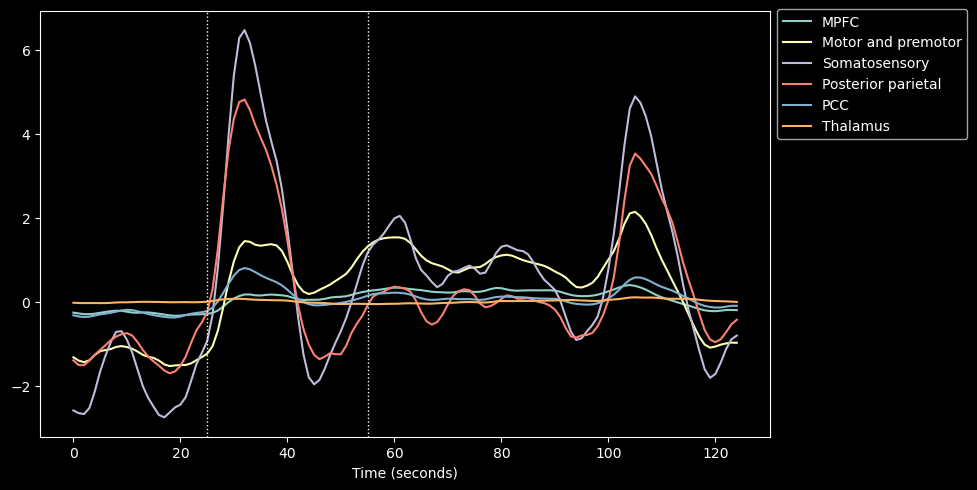

In [271]:
plt.figure(figsize=(10, 5))

# Plot each key's time series in a different color
for region, data in zip(selected_region.keys(), mean_selected_region_trial_data):
    plt.plot(data, label=region)

# # Add vertical lines for each event
plt.axvline(x=10*2.5, color='white', linestyle='dotted', linewidth=1)
plt.axvline(x=10*2.5+30, color='white', linestyle='dotted', linewidth=1)

# Customize plot
plt.xlabel("Time (seconds)")
# plt.ylabel("Signal (e.g., Percent Signal Change)")
# plt.legend(loc='upper right')
# plt.title("Selected Cortical Regions Over Time with Event Markers")
# plt.grid(True)
plt.legend(bbox_to_anchor=(1.28, 1.02))

# Show plot
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'selected_region_psth.svg'), dpi=300)
plt.show()